In [27]:
from collections import defaultdict
from itertools import combinations

# 1. 一个小函数，计算一个 DNA 串的反向互补
def revcomp(seq: str) -> str:
    comp = {'A':'T','T':'A','C':'G','G':'C'}
    return ''.join(comp[c] for c in reversed(seq))

print(revcomp('ATCG'))

# 2. 建两个索引：正向和倒位
def build_bi_strand_index(reference: str, k: int, d: int):
    """
    返回：
      masks,             # LSH 掩码列表
      idx_pos, idx_neg   # 两个 List[Dict]，分别是正向和倒位索引
    """
    masks = list(combinations(range(k), k - d))
    idx_pos = []  # 正向索引
    idx_neg = []  # 倒位索引（对反向互补建表）
    rc_ref = revcomp(reference)
    
    n=len(reference)

    for mask in masks:
        m_pos = defaultdict(list)
        m_neg = defaultdict(list)
        for i in range(n - k + 1):
            kmer_pos = reference[i:i+k]
            key_pos = hash(tuple(kmer_pos[p] for p in mask))
            m_pos[key_pos].append(i)

            kmer_neg=rc_ref[n-(i+k):n-(i)]
            key_neg = hash(tuple(kmer_neg[p] for p in mask))
            m_neg[key_neg].append(i)
            
            
            
        idx_pos.append(m_pos)
        idx_neg.append(m_neg)

    return masks, idx_pos, idx_neg

# 3. 查 query 时，同一个 k-mer 既在正向，也在倒位里查
def match_bi_strand(query: str, k: int, d: int, masks, idx_pos, idx_neg):
    """
    返回 List[(q_pos, r_pos, strand)]
    strand = +1 (正向) 或 -1 (倒位)
    """
    anchors = []
    anchors_r = []
    for q in range(len(query) - k + 1):
        kmer = query[q:q+k]
        # kmer_rc = revcomp(kmer)
        for mask, m_pos, m_neg in zip(masks, idx_pos, idx_neg):
            key = hash(tuple(kmer[p] for p in mask))
            for r in m_pos.get(key, []):
                anchors.append((q, r))
            for r in m_neg.get(key, []):
                anchors_r.append((q, r))
    # 去重
    return list(set(anchors)), list(set(anchors_r))

# —— 使用示例 —— #




CGAT


In [ ]:
# ———————— 使用示例 ————————

# 假设：
# reference = "ACTGATCATGATCGTAGCT"  # 长百万级的字符串
# query     = "ACCGAACATGCTCGGAGAT"      # 待比对字符串
def read_sequence_from_file(path: str) -> str:
    """
    从文本文件读取 DNA 序列：
    - 忽略空行和首尾空白
    - 返回纯净的字符串（只包含 A/C/G/T）
    """
    with open(path, "r") as f:
        # 读取每一行，去掉首尾空白，过滤空行
        lines = [line.strip() for line in f if line.strip()]
    # 将多行拼接成一个连续序列
    return "".join(lines)

# 调用示例
reference = read_sequence_from_file("ref1.txt")
query     = read_sequence_from_file("que1.txt")
k, d      = 11, 2

# 1. 建双链索引
masks, idx_pos, idx_neg = build_bi_strand_index(reference, k, d)

# 2. 匹配
anchors ,anchors_r= match_bi_strand(query, k, d, masks, idx_pos, idx_neg)
print("anchors:", anchors[:10])
print("anchors_r:", anchors_r[:10])
# 每个元素是 (q_pos, r_pos, strand)

print("找到的锚点数量len(anchors)：", len(anchors))
print("部分锚点示例：", anchors[:10])
for i, (q_pos, r_pos) in enumerate(anchors[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")

print("找到的锚点数量len(anchors)：", len(anchors_r))
print("部分锚点示例：", anchors_r[:10])
for i, (q_pos, r_pos) in enumerate(anchors_r[:10], 1):   #索引从1开始计数
    q_kmer = query[q_pos : q_pos + k]
    r_kmer = reference[r_pos : r_pos + k]
    print(f"{i:2d}. query[{q_pos:4d}:{q_pos+k:4d}] = {q_kmer}    "
          f"| reference[{r_pos:4d}:{r_pos+k:4d}] = {r_kmer} ")


anchors: [(788, 838), (774, 674), (130, 380), (1513, 1013), (695, 795), (1820, 1170), (533, 733), (1658, 1108), (247, 147), (1096, 846)]
anchors_r: [(1273, 916), (222, 1244), (969, 770), (963, 726), (2448, 1407), (405, 584), (62, 739), (1175, 874), (1122, 719), (2054, 699)]
找到的锚点数量len(anchors)： 5630
部分锚点示例： [(788, 838), (774, 674), (130, 380), (1513, 1013), (695, 795), (1820, 1170), (533, 733), (1658, 1108), (247, 147), (1096, 846)]
 1. query[ 788: 799] = GTGGCGTTTGC    | reference[ 838: 849] = GTGGCGTTTGC 
 2. query[ 774: 785] = CTAGGGCACGA    | reference[ 674: 685] = CTATGGCACAA 
 3. query[ 130: 141] = TGGGAAATACT    | reference[ 380: 391] = TCCGAAATACT 
 4. query[1513:1524] = TATCTTTCAGC    | reference[1013:1024] = TATCTTTCAGC 
 5. query[ 695: 706] = TTGCCCCCGCG    | reference[ 795: 806] = TTGCCCCCGTG 
 6. query[1820:1831] = CAGCGCCTGCG    | reference[1170:1181] = GAGCGCTTGCG 
 7. query[ 533: 544] = GACGGGTGGCG    | reference[ 733: 744] = GGCGGGTGGCG 
 8. query[1658:1669] = CTAAAGGG

: 

: 

anchor q0=788, r0=838
anchor q1=405, r1=584
TATGACACCAAAAGATCTACCTACAGCCCG
CAGTACTGTAGGTATATCTTTTGGTGTCAT
TATGACACCA  AAAGATCTACC  TACAGCCCG
CAGTACTGTA  GGTATATCTTT  TGGTGTCAT


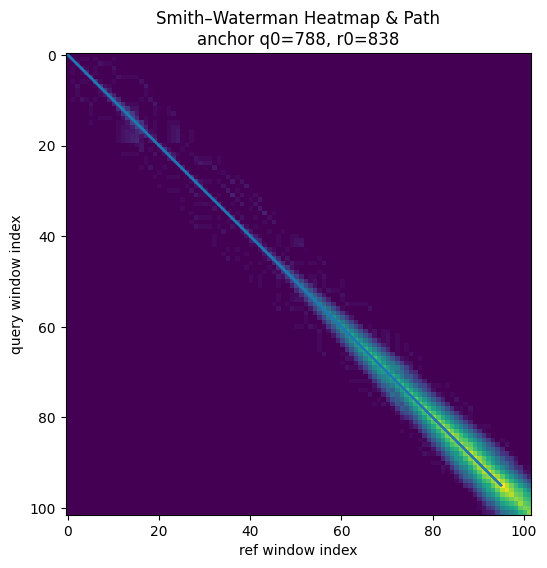

Aligned fragment:
 query[738:832] = GTGGCGTTTGCCCTCCCCCAGCTTGACTACTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGCGCAGCTCGACTTTTGTGCTCTATGGCAC
 ref  [788:882] = GTGGCGTTTGCCCCCGTGCAGCCCGACTTTTGTACTCTAGTGCACGACGGGTGGCGTTTGCCCCCGCACCGCTCGACTTTTGTGATCTAGGGCAC
Best score: 92


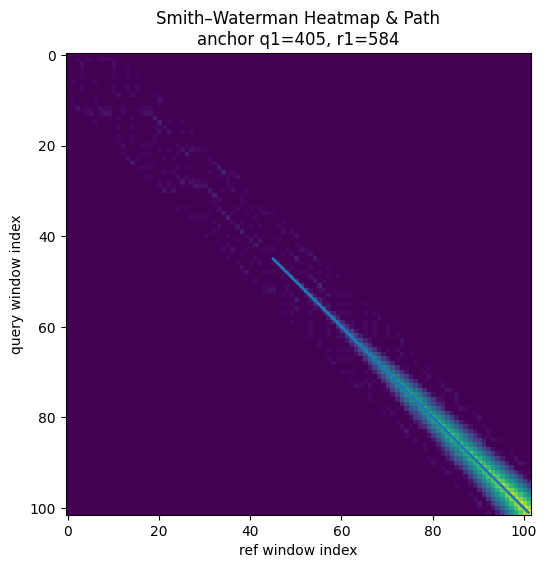

q_st: 400 q_en: 455 r_st: 544 r_en: 599 r_st_r: 1100 r_en_r: 1155
Aligned fragment:
 query[400:455] = CTGTAGGTATATCTTTTGGTGTCATATGAGGGTACTGAACTTGACGACCGCGACCA
 ref  [544:599] = TGGTCGCGGTCGTCAACTTCAGTACGCTCATATGACACCAAAAGATCTACCTACAG
Best score: 91


: 

: 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt





def compute_banded_sw_matrix(ref, query, r0, q0,
                             W=50, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    本函数返回：
      H:    (n+1)x(m+1) 的得分矩阵
      path: 回溯路径列表 [(i1,j1),...,(ik,jk)]
      q_lo, r_lo: 窗口在原始序列中的左边界
    """
    # 定义窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 初始化
    H = np.zeros((n+1, m+1), dtype=int)
    best_score, bi, bj = 0, 0, 0

    # 填表
    for i in range(1, n+1):
        j_start = max(1, i - band)
        j_end   = min(m, i + band)
        for j in range(j_start, j_end+1):
            sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            diag = H[i-1, j-1] + sc
            up   = H[i-1, j]   + gap
            left = H[i,   j-1] + gap
            H[i, j] = val = max(0, diag, up, left)
            if val > best_score:
                best_score, bi, bj = val, i, j

    # 回溯
    path = []
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        path.append((i, j))
        sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
        if H[i, j] == H[i-1, j-1] + sc:
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1
    path.append((i, j))
    path.reverse()
    return H, path, q_lo, r_lo


# 选一个 anchor，比如第 1 个
q0, r0 = anchors[0]
q1, r1 = anchors_r[5]

reference_r=revcomp(reference)
print(f"anchor q0={q0}, r0={r0}")
print(f"anchor q1={q1}, r1={r1}")
print(reference[r1-10:r1+20])
print(query[q1-10:q1+20])
print(reference[r1-10:r1]+'  '+reference[r1:r1+11]+'  '+reference[r1+11:r1+20])
print(query[q1-10:q1]+'  '+query[q1:q1+11]+'  '+query[q1+11:q1+20])

len_ref=len(reference) 


r1_r=(len_ref-1)-(r1+10)

# 计算矩阵和路径
H, path, q_lo, r_lo = compute_banded_sw_matrix(reference, query, r0, q0)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q0={q0}, r0={r0}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st = r_lo + j0
r_en = r_lo + bj - 1

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())

#_____________________________________________________________________________________



H, path, q_lo, r_lo = compute_banded_sw_matrix(reference_r, query, r1_r, q1)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q1={q1}, r1={r1}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st_r = r_lo + j0
r_en_r = r_lo + bj - 1

r_st=len_ref-1-r_en_r
r_en=len_ref-1-r_st_r
print("q_st:", q_st, "q_en:", q_en, "r_st:", r_st, "r_en:", r_en,"r_st_r:", r_st_r,"r_en_r:", r_en_r)

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {query[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {reference[r_st:r_en+1]}")
print("Best score:", H.max())


ref: TATGACACCAAAAGATCTACCTACAGCCCG
que: CAGTACTGTAGGTATATCTTTTGGTGTCAT
ref_r: CGGGCTGTAGGTAGATCTTTTGGTGTCATA
q_lo=0, q_hi=21, r_lo=0, r_hi=20


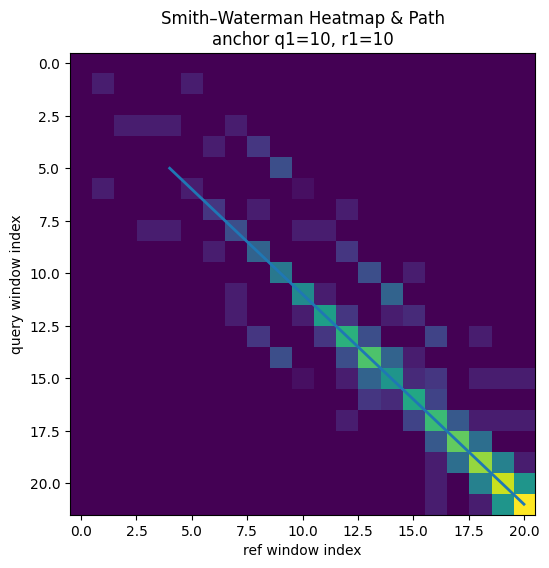

q_st: 5 q_en: 20 r_st: 10 r_en: 25 r_st_r: 4 r_en_r: 19
Aligned fragment:
 query[5:20] = CTGTAGGTATATCTTT
 ref  [10:25] = AAAGATCTACCTACAG
Best score: 25


: 

: 

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

# 选一个 anchor，比如第 1 个
q0, r0 = anchors[0]
q1, r1 = anchors_r[5]

ref="TATGACACCAAAAGATCTACCTACAGCCCG"
que="CAGTACTGTAGGTATATCTTTTGGTGTCAT"

ref_r=revcomp(ref)

print("ref:", ref)
print("que:", que)
print("ref_r:", ref_r)

r1=10
q1=10

len_ref=len(ref) 
len_que=len(que) 

r1_r=(len_ref-1)-(r1+10)










def compute_banded_sw_matrix(ref, query, r0, q0,
                             W=10, band=5,
                             match=2, mismatch=-5, gap=-10):
    """
    本函数返回：
      H:    (n+1)x(m+1) 的得分矩阵
      path: 回溯路径列表 [(i1,j1),...,(ik,jk)]
      q_lo, r_lo: 窗口在原始序列中的左边界
    """
    # 定义窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    print(f"q_lo={q_lo}, q_hi={q_hi}, r_lo={r_lo}, r_hi={r_hi}")
    n, m = q_hi - q_lo, r_hi - r_lo

    # 初始化
    H = np.zeros((n+1, m+1), dtype=int)
    best_score, bi, bj = 0, 0, 0

    # 填表
    for i in range(1, n+1):
        j_start = max(1, i - band)
        j_end   = min(m, i + band)
        for j in range(j_start, j_end+1):
            sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            diag = H[i-1, j-1] + sc
            up   = H[i-1, j]   + gap
            left = H[i,   j-1] + gap
            H[i, j] = val = max(0, diag, up, left)
            if val > best_score:
                best_score, bi, bj = val, i, j

    # 回溯
    path = []
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        path.append((i, j))
        sc = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
        if H[i, j] == H[i-1, j-1] + sc:
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1
    path.append((i, j))
    path.reverse()
    return H, path, q_lo, r_lo






H, path, q_lo, r_lo = compute_banded_sw_matrix(ref_r, que, r1_r, q1)

# 可视化得分矩阵和回溯路径
plt.figure(figsize=(6, 6))
plt.imshow(H, aspect='auto')
ys, xs = zip(*path)
plt.plot(xs, ys, linewidth=2)
plt.title(f"Smith–Waterman Heatmap & Path\nanchor q1={q1}, r1={r1}")
plt.xlabel("ref window index")
plt.ylabel("query window index")
plt.show()

# 将回溯结果映射回原始序列坐标并打印
i0, j0 = path[0]
bi, bj = path[-1]
q_st = q_lo + i0
q_en = q_lo + bi - 1
r_st_r = r_lo + j0
r_en_r = r_lo + bj - 1

r_st=len_ref-1-r_en_r
r_en=len_ref-1-r_st_r
print("q_st:", q_st, "q_en:", q_en, "r_st:", r_st, "r_en:", r_en,"r_st_r:", r_st_r,"r_en_r:", r_en_r)

print("Aligned fragment:")
print(f" query[{q_st}:{q_en}] = {que[q_st:q_en+1]}")
print(f" ref  [{r_st}:{r_en}] = {ref[r_st:r_en+1]}")
print("Best score:", H.max())


In [ ]:
import numpy as np

def compute_banded_sw_simple(ref, query, r0, q0,
                             W=100, band=10,
                             match=2, mismatch=-5, gap=-10):
    """
    带宽限制的 Smith-Waterman 局部对齐——简洁版
    输入:
      ref, query: DNA 序列
      r0, q0: 种子锚点在 ref/query 上的位置
      W: 窗口半宽度，band: 带宽优化
      match/mismatch/gap: 计分
    输出:
      (q_start, q_end, r_start, r_end, best_score)
    """
    # 1. 定义局部对齐窗口
    q_lo = max(0, q0 - W); q_hi = min(len(query), q0 + W + 1)
    r_lo = max(0, r0 - W); r_hi = min(len(ref),   r0 + W + 1)
    n, m = q_hi - q_lo, r_hi - r_lo

    # 2. DP 矩阵，只存两行滚动优化也可以，这里为了回溯保留全矩阵
    H = np.zeros((n+1, m+1), dtype=int)
    best, bi, bj = 0, 0, 0

    # 3. 填表
    for i in range(1, n+1):
        j0 = max(1, i - band); j1 = min(m, i + band)
        for j in range(j0, j1+1):
            s = match if query[q_lo+i-1] == ref[r_lo+j-1] else mismatch
            v = max(0,
                    H[i-1, j-1] + s,
                    H[i-1, j]   + gap,
                    H[i,   j-1] + gap)
            H[i, j] = v
            if v > best:
                best, bi, bj = v.item(), i, j

    # 4. 回溯到局部起点
    i, j = bi, bj
    while i>0 and j>0 and H[i, j] > 0:
        # 优先判断对角线
        if H[i, j] == H[i-1, j-1] + (match if query[q_lo+i-1]==ref[r_lo+j-1] else mismatch):
            i, j = i-1, j-1
        elif H[i, j] == H[i-1, j] + gap:
            i -= 1
        else:
            j -= 1

    # 5. 映射到全局坐标并返回
    q_start = q_lo + i
    q_end   = q_lo + bi - 1
    r_start = r_lo + j
    r_end   = r_lo + bj - 1
    return (q_start, q_end, r_start, r_end, best)

fragments=[]
fragments_r=[]

for q0,r0 in anchors:
    frag = compute_banded_sw_simple(reference, query, r0, q0,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        frag=frag+(1,)
        fragments.append(frag)
       
len_ref=len(reference) 
for q1,r1 in anchors_r:
    r1_r=(len_ref-1)-(r1+10)
    frag=compute_banded_sw_simple(reference_r, query, r1_r, q1,
                                    W=100, band=10,
                                    match=2, mismatch=-5, gap=-10)
    if frag:
        lst=list(frag)
        r_start_r=lst[2]
        r_end_r=lst[3]
        lst[2]=len_ref-1-r_end_r
        lst[3]=len_ref-1-r_start_r
        frag=tuple(lst)
        frag=frag+(-1,)
        fragments_r.append(frag)
        
        
print(len(fragments))
print(fragments[:10])

print(len(fragments_r))
print(fragments_r[:10])




#关键参数：W，band


5630
[(688, 832, 738, 882, 157, 1), (700, 874, 600, 774, 217, 1), (99, 150, 349, 400, 34, 1), (1500, 1613, 1000, 1113, 200, 1), (595, 795, 695, 895, 262, 1), (1749, 1897, 1099, 1247, 74, 1), (507, 633, 707, 833, 135, 1), (1721, 1756, 1171, 1206, 44, 1), (202, 269, 102, 169, 45, 1), (1002, 1136, 752, 886, 130, 1)]
1329
[(1200, 1299, 900, 999, 193, -1), (272, 278, 1198, 1204, 14, -1), (900, 997, 752, 849, 98, -1), (900, 999, 700, 799, 172, -1), (2438, 2443, 1430, 1435, 12, -1), (400, 500, 499, 599, 167, -1), (8, 11, 842, 845, 8, -1), (1175, 1185, 874, 884, 15, -1), (1124, 1132, 719, 727, 18, -1), (2054, 2067, 696, 709, 21, -1)]


: 

: 

In [ ]:
qs, qe, rs, re, sc, strand = fragments[0]
print("正向第一个片段：")
print(f"  query[{qs}:{qe}]  = {query[qs:qe+1]}")
print(f"  ref  [{rs}:{re}]  = {reference[rs:re+1]}")
print(f"  score = {sc}, strand = {strand}")

# 打印反向匹配的第一个片段
qs, qe, rs, re, sc, strand = fragments_r[0]
print("\n反向第一个片段：")
print(f"  query[{qs}:{qe}]  = {query[qs:qe+1]}")
print(f"  ref  [{rs}:{re}]  = {reference[rs:re+1]}")
print(f"  score = {sc}, strand = {strand}")

正向第一个片段：
  query[688:832]  = GTGGCCTTTGCCCCCGCGCAGCTGGACTTTTGTGCTCTAGGGCACGGCGGGTGGCGTTTGCCCTCCCCCAGCTTGACTACTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGCGCAGCTCGACTTTTGTGCTCTATGGCAC
  ref  [738:882]  = GTGGCGTTTGCCCTCGCCCAGCTTGACTTTTGTGCTCTAGGGCACGACGGGTGGCGTTTGCCCCCGTGCAGCCCGACTTTTGTACTCTAGTGCACGACGGGTGGCGTTTGCCCCCGCACCGCTCGACTTTTGTGATCTAGGGCAC
  score = 157, strand = 1

反向第一个片段：
  query[1200:1299]  = AGCTTTCCGTATCTACCTAATGTCTTCCTCTCAGACCCGTCTCACGGGCCAATGAGAAGCGCGGGGCCTATTAGAGAATCCATGTGCGTTGATCTGTCTG
  ref  [900:999]  = CAGACAGATCAACGCACATGGATTCTCTAACAGGCCCCGCGCTTCTCATTGGCCCGTGAGACGGGTCTGAGAGGAAGACATTAGGTAGATACGGAAAGCT
  score = 193, strand = -1


: 

: 

[(0, 200, 0, 200), (0, 199, 0, 199), (0, 198, 0, 198), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 193, 0, 193), (0, 192, 0, 192), (0, 191, 0, 191), (0, 190, 0, 190), (0, 189, 0, 189), (0, 188, 0, 188), (0, 187, 0, 187), (0, 186, 0, 186), (0, 185, 0, 185), (0, 184, 0, 184), (0, 183, 0, 183), (0, 182, 0, 182), (0, 181, 0, 181), (0, 180, 0, 180), (0, 179, 0, 179), (0, 178, 0, 178), (0, 177, 0, 177), (0, 176, 0, 176), (0, 175, 0, 175), (0, 174, 0, 174), (0, 173, 0, 173), (0, 172, 0, 172), (0, 171, 0, 171), (0, 170, 0, 170), (0, 169, 0, 169), (0, 168, 0, 168), (0, 167, 0, 167), (0, 166, 0, 166), (0, 165, 0, 165), (0, 164, 0, 164), (0, 163, 0, 163), (0, 162, 0, 162), (0, 161, 0, 161), (0, 160, 0, 160), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 151, 0, 151), (0, 150, 0, 150), (0, 149, 0, 149), (0, 148, 0, 148), (0, 147, 0, 147), (0, 146, 0, 146), (0, 145, 

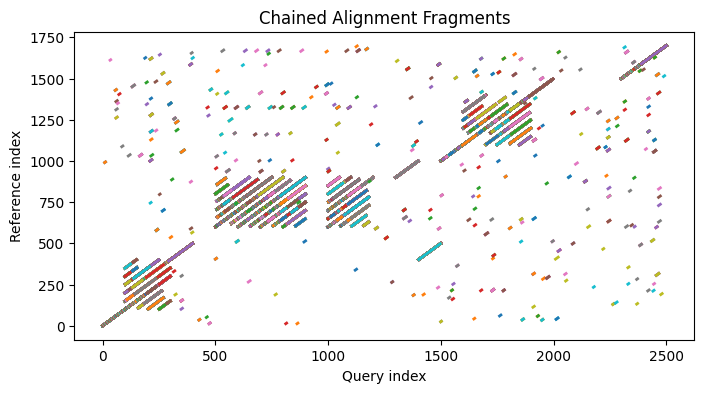

: 

: 

In [ ]:
# 假设你已有 fragments 列表，每个元素是 (q_start, q_end, r_start, r_end, score)
# 下面实现贪心链式拼接

def chain_fragments_greedy(fragments):
    """
    输入:
      fragments: List of tuples (q_start, q_end, r_start, r_end, score)
    输出:
      chained: 按 Query 顺序、不重叠的最优贪心链
    """
    # 1. 按 q_start 升序；若相同则按 score 降序
    frags = sorted(fragments, key=lambda x: (x[0], -x[4]))
    chained = []
    ans=[]
    last_q_end = -1
    for qs, qe, rs, re, sc,_ in frags:
        # if qs > last_q_end:
        #   chained.append((qs, qe, rs, re, sc))
        #   ans.append((qs, qe, rs, re))
        #   last_q_end = qe
      
        chained.append((qs, qe, rs, re, sc))
        ans.append((qs, qe, rs, re))
        last_q_end = qe
    return chained,ans

# 调用示例
chained ,ans= chain_fragments_greedy(fragments)

print(ans)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")

# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained:
    plt.plot([qs, qe], [rs, re], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()





[(3, 7, 1513, 1517), (5, 8, 589, 592), (8, 11, 842, 845), (9, 12, 953, 956), (9, 12, 953, 956), (9, 12, 953, 956), (25, 28, 556, 559), (28, 40, 855, 867), (31, 34, 1424, 1427), (42, 48, 1354, 1360), (42, 48, 1354, 1360), (42, 47, 1155, 1160), (42, 47, 1155, 1160), (56, 60, 815, 819), (56, 60, 715, 719), (56, 60, 715, 719), (87, 91, 858, 862), (87, 91, 708, 712), (120, 125, 1444, 1449), (122, 126, 1604, 1608), (140, 145, 1282, 1287), (140, 145, 1480, 1485), (140, 145, 1282, 1287), (140, 145, 1282, 1287), (148, 154, 246, 252), (148, 154, 246, 252), (148, 154, 246, 252), (148, 154, 246, 252), (151, 156, 294, 299), (153, 157, 1115, 1119), (166, 171, 1066, 1071), (166, 171, 1066, 1071), (166, 171, 1066, 1071), (180, 189, 1563, 1572), (180, 189, 1563, 1572), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (181, 193, 493, 505), (211, 219, 988, 996), (224, 229, 575, 580), (228, 235, 230, 237), (228, 235, 230, 237), (228, 235, 330, 3

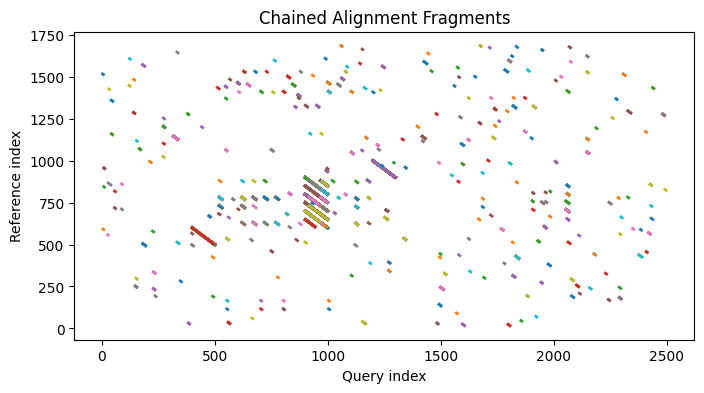

: 

: 

In [ ]:
# 假设你已有 fragments 列表，每个元素是 (q_start, q_end, r_start, r_end, score)
# 下面实现贪心链式拼接

# 调用示例
chained_r ,ans_r= chain_fragments_greedy(fragments_r)

print(ans_r)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")

# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained_r:
    plt.plot([qs, qe], [re, rs], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()


[(0, 200, 0, 200), (0, 199, 0, 199), (0, 198, 0, 198), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 194, 0, 194), (0, 193, 0, 193), (0, 192, 0, 192), (0, 191, 0, 191), (0, 190, 0, 190), (0, 189, 0, 189), (0, 188, 0, 188), (0, 187, 0, 187), (0, 186, 0, 186), (0, 185, 0, 185), (0, 184, 0, 184), (0, 183, 0, 183), (0, 182, 0, 182), (0, 181, 0, 181), (0, 180, 0, 180), (0, 179, 0, 179), (0, 178, 0, 178), (0, 177, 0, 177), (0, 176, 0, 176), (0, 175, 0, 175), (0, 174, 0, 174), (0, 173, 0, 173), (0, 172, 0, 172), (0, 171, 0, 171), (0, 170, 0, 170), (0, 169, 0, 169), (0, 168, 0, 168), (0, 167, 0, 167), (0, 166, 0, 166), (0, 165, 0, 165), (0, 164, 0, 164), (0, 163, 0, 163), (0, 162, 0, 162), (0, 161, 0, 161), (0, 160, 0, 160), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 152, 0, 152), (0, 151, 0, 151), (0, 150, 0, 150), (0, 149, 0, 149), (0, 148, 0, 148), (0, 147, 0, 147), (0, 146, 0, 146), (0, 145, 

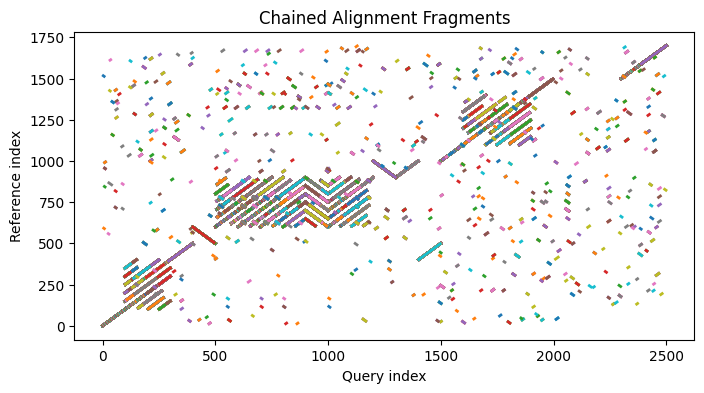

: 

: 

In [ ]:
chained ,ans= chain_fragments_greedy(fragments)
chained_r ,ans_r= chain_fragments_greedy(fragments_r)


print(ans)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")
print(ans_r)
print("Greedy Chained Fragments:")
for idx, (qs, qe, rs, re, sc) in enumerate(chained, 1):
    print(f"{idx}. query[{qs}:{qe}] ↔ ref[{rs}:{re}]  score={sc}")
# （可选）可视化每个片段在 Query/Ref 上的位置
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
for qs, qe, rs, re, sc in chained:
    plt.plot([qs, qe], [rs, re], linewidth=2)
for qs, qe, rs, re, sc in chained_r:
    plt.plot([qs, qe], [re, rs], linewidth=2)
plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()

  





过滤前共有 6959 段
过滤后剩下 5741 段
最终可视化用片段：
15
[(0, 200, 0, 200), (202, 269, 102, 169), (282, 399, 382, 499), (400, 500, 499, 599), (501, 701, 601, 801), (702, 899, 702, 899), (900, 999, 700, 799), (1000, 1199, 700, 899), (1200, 1299, 900, 999), (1300, 1399, 900, 999), (1402, 1500, 402, 500), (1501, 1617, 1001, 1117), (1622, 1792, 1172, 1342), (1793, 1993, 1293, 1493), (2299, 2499, 1499, 1699)]
15


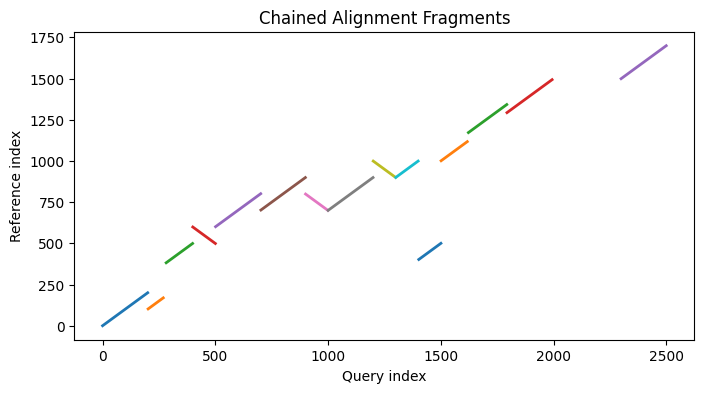

: 

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def filter_fragments(fragments, min_len=20):
    """
    过滤：
      1. query 上长度 < min_len 的片段
      2. 被同向上、得分更高的片段完全覆盖的片段
    fragments: List of (qs, qe, rs, re, sc, strand)
    return: List of kept fragments (same format)
    """
    # 先按 (qs asc, length desc, score desc) 排好
    fr = sorted(fragments, key=lambda x: (x[0], -(x[1]-x[0]+1), -x[4]))
    kept = []
    for i, (qs_a, qe_a, rs_a, re_a, sc_a, sgn_a) in enumerate(fr):
        length = qe_a - qs_a + 1
        if length < min_len:
            continue
        kept.append((qs_a, qe_a, rs_a, re_a, sc_a, sgn_a))
        # covered = False
        # for (qs_b, qe_b, rs_b, re_b, sc_b, sgn_b) in kept:
        #     if sgn_a == sgn_b \
        #        and qs_b <= qs_a and qe_a <= qe_b \
        #        and sc_b >= sc_a:
        #         covered = True
        #         break
        # if not covered:
        #     kept.append((qs_a, qe_a, rs_a, re_a, sc_a, sgn_a))
    return kept

# =====================
# 1. 假设你已有 fragments 和 fragments_r
#    每个元组都是 (q_start, q_end, r_start, r_end, score, strand)

all_frags = fragments + fragments_r

# 2. 过滤掉过短和被覆盖的
min_len = 20   #100
print(f"过滤前共有 {len(all_frags)} 段")
filtered = filter_fragments(all_frags, min_len=min_len)
print(f"过滤后剩下 {len(filtered)} 段")

# 3. 用最简单的“贪心”按 qs 排序，挑一条不重叠链（只用于可视化示例）
def greedy_chain(frags):
    frags = sorted(frags, key=lambda x: (x[0], -x[4]))
    chain = []
    last_q_end = -1
    for qs, qe, rs, re, sc, sgn in frags:
        if qs > last_q_end:
            chain.append((qs, qe, rs, re, sc, sgn))
            last_q_end = qe
    return chain

chain = greedy_chain(filtered)

ans1=[]
print("最终可视化用片段：")


cnt=0
# for qs, qe, rs, re, sc, sgn in filtered:
for qs, qe, rs, re, sc, sgn in chain:
    cnt+=1
    dirc = "→" if sgn==1 else "←"
    # print(f" q[{qs}:{qe}] {dirc} r[{rs}:{re}]  len={qe-qs+1}  sc={sc}")
    ans1.append((qs, qe, rs, re))
    
    
print(len(ans1))
print(ans1)
print(cnt)

# 4. 可视化
plt.figure(figsize=(8,4))
# for qs, qe, rs, re, sc, sgn in filtered:
for qs, qe, rs, re, sc, sgn in chain:
    if sgn == 1:
        plt.plot([qs, qe], [rs, re], lw=2)
    else:
        # 倒序片段要画反向连线：q从小到大，ref从大到小
        plt.plot([qs, qe], [re, rs], lw=2)

plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()

#（1994,2298,0,1304）


[(0, 300, 0, 300), (601, 899, 601, 899), (99, 300, 149, 350), (571, 832, 621, 882), (99, 399, 199, 499), (501, 800, 601, 900), (99, 152, 299, 352), (507, 686, 707, 886), (99, 150, 349, 400), (507, 650, 757, 900), (101, 249, 251, 399), (509, 750, 659, 900), (159, 261, 109, 211), (656, 899, 606, 849), (202, 269, 102, 169), (700, 899, 600, 799), (251, 300, 101, 150), (756, 899, 606, 749), (1000, 1050, 850, 900), (317, 336, 1127, 1146), (400, 500, 499, 599), (501, 554, 801, 854), (508, 545, 858, 895), (800, 899, 600, 699), (1000, 1100, 800, 900), (856, 898, 606, 648), (1002, 1136, 752, 886), (900, 1000, 599, 699), (900, 999, 700, 799), (900, 999, 650, 749), (900, 999, 800, 899), (900, 997, 752, 849), (901, 943, 606, 648), (968, 999, 850, 881), (999, 1180, 599, 780), (1300, 1399, 900, 999), (1599, 1742, 1199, 1342), (1759, 1785, 1359, 1385), (1000, 1199, 700, 899), (1598, 1699, 1298, 1399), (1000, 1170, 650, 820), (1598, 1681, 1248, 1331), (1056, 1180, 606, 730), (1622, 1792, 1172, 1342), (

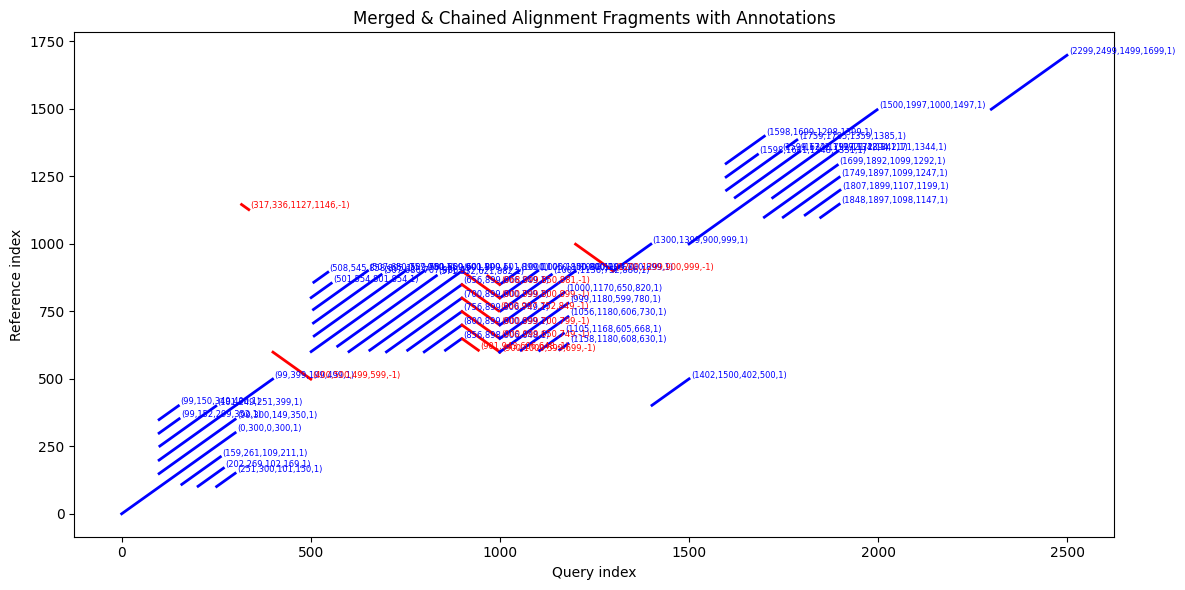

: 

: 

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def merge_aligned_fragments(fragments):
    groups = defaultdict(list)
    # 1) 按 strand 和 offset 分组
    for qs, qe, rs, re, sc, strand in fragments:
        offset = rs - qs if strand==1 else (rs + qe)  # 对逆向，这个 offset 使得 re + qs = const
        groups[(strand, offset)].append((qs, qe))

    merged = []
    # 2) 对每组里的 intervals 合并重叠或相接
    for (strand, offset), intervals in groups.items():
        intervals.sort()
        cur_s, cur_e = intervals[0]
        for s, e in intervals[1:]:
            if s <= cur_e + 1:         # 重叠或相接
                cur_e = max(cur_e, e)
            else:
                # 把上一段输出
                if strand==1:
                    rs, re = cur_s + offset, cur_e + offset
                else:
                    # 逆向：rs/re 距离 qs/ qe 保持反向关系
                    re = offset - cur_s
                    rs = offset - cur_e
                merged.append((cur_s, cur_e, rs, re, strand))
                cur_s, cur_e = s, e

        # 最后一段
        if strand==1:
            rs, re = cur_s + offset, cur_e + offset
        else:
            re = offset - cur_s
            rs = offset - cur_e
        merged.append((cur_s, cur_e, rs, re, strand))

    return merged

# ———— 假设 filtered 是你的原始 fragments ————
# merged = merge_aligned_fragments(filtered)


merged = merge_aligned_fragments(filtered)
ans = []
for qs, qe, rs, re, strand in merged:
    ans.append((qs, qe, rs, re))
print(ans)

plt.figure(figsize=(12, 6))
for qs, qe, rs, re, strand in merged:
    if strand == 1:
        x_vals = [qs, qe]
        y_vals = [rs, re]
        color = 'b'
    else:
        x_vals = [qs, qe]
        y_vals = [re, rs]  # 反向时交换
        color = 'r'
    plt.plot(x_vals, y_vals, color=color, lw=2)
    # 在每条线的末端标注其元组
    label = f"({qs},{qe},{rs},{re},{strand})"
    plt.text(x_vals[1] + 5, y_vals[1] + 5, label, fontsize=6, color=color)

plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Merged & Chained Alignment Fragments with Annotations")
plt.tight_layout()
plt.show()


In [ ]:

import numpy as np
from numba import njit
import edlib


def get_rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)
def rc(s):
    map_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}
    l = []
    for c in s:
        l.append(map_dict[c])
    l = l[::-1]
    return ''.join(l)

def seq2hashtable_multi_test(refseq, testseq, kmersize=15, shift = 1):
    rc_testseq = get_rc(testseq)
    testseq_len = len(testseq)
    local_lookuptable = dict()
    skiphash = hash('N'*kmersize)
    for iloc in range(0, len(refseq) - kmersize + 1, 1):
        hashedkmer = hash(refseq[iloc:iloc+kmersize])
        if(skiphash == hashedkmer):
            continue
        if(hashedkmer in local_lookuptable):

            local_lookuptable[hashedkmer].append(iloc)
        else:
            local_lookuptable[hashedkmer] = [iloc]
    iloc = -1
    readend = testseq_len-kmersize+1
    one_mapinfo = []
    preiloc = 0
    while(True):
   
        iloc += shift
        if(iloc >= readend):
            break

        #if(hash(testseq[iloc: iloc + kmersize]) == hash(rc_testseq[-(iloc + kmersize): -iloc])):
            #continue
 
        hashedkmer = hash(testseq[iloc: iloc + kmersize])
        if(hashedkmer in local_lookuptable):

            for refloc in local_lookuptable[hashedkmer]:

                one_mapinfo.append((iloc, refloc, 1, kmersize))



        hashedkmer = hash(rc_testseq[-(iloc + kmersize): -iloc])
        if(hashedkmer in local_lookuptable):
            for refloc in local_lookuptable[hashedkmer]:
                one_mapinfo.append((iloc, refloc, -1, kmersize))
        preiloc = iloc

    

    return np.array(one_mapinfo)

def get_points(tuples_str):
    data = []
    num = 0
    for c in tuples_str:
        if(ord('0') <= c <= ord('9')):
            num = num * 10 + c - ord('0')
        elif(ord(',') == c):
            data.append(num)
            num = 0
    if(num != 0):
        data.append(num)
    return data

def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    _a = rc(query[query_st: query_en])
    return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])

def get_first(x):
    return x[0]


def calculate_value(tuples_str, ref, query):  

    slicepoints = np.array(get_points(tuples_str.encode()))
    if(len(slicepoints) > 0 and len(slicepoints) % 4 == 0):
        print(len(slicepoints))
        editdistance = 0
        aligned = 0
        preend = 0
        points = np.array(slicepoints).reshape((-1, 4)).tolist()
        print(points)
        points.sort(key=get_first)
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple
            if(preend > query_st):
                print(f"overlapped!")
                return 0
            if(query_en - query_st < 30):
                print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}"+"too short!")
                continue
            preend = query_en
            if((calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)/len(query[query_st:query_en])) > 0.1):
                print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}"+f"too different!:cal_dis:{calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)}, aligned:{len(query[query_st:query_en])}")
                continue
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += len(query[query_st:query_en])
            print(f"query_st:{query_st}, query_en:{query_en}, ref_st:{ref_st}, ref_en:{ref_en}:cal_dis:{calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)}, aligned:{len(query[query_st:query_en])}")
            
        print(f"editdistance:{editdistance}, aligned:{aligned}")
        return max(aligned - editdistance, 0)
    else:
        print(len(slicepoints))
        return 0


: 

: 

In [ ]:
#ans4:2074
ans4=[(0, 300, 0, 300),(300,399, 400, 499),(400, 500, 499, 599),(500, 800, 600, 900), (800, 899, 700, 799),(900, 999, 700, 799),(1000, 1199, 700, 899),(1200, 1299, 900, 999),(1300, 1399, 900, 999),(1402, 1500, 402, 500),(1500, 1617, 1000, 1117),   (1617, 1699, 1317, 1399),(1699, 1801, 1199, 1301),(1807, 1899, 1107, 1199), (1899, 1997, 1399, 1497), (2299, 2499, 1499, 1699)]
#ans3:1968
ans3=[(0, 300, 0, 300),(301,399, 401, 499),(400, 500, 499, 599),(501, 800, 601, 900), (801, 899, 701, 799),(900, 999, 700, 799),(1000, 1199, 700, 899),(1200, 1299, 900, 999),(1300, 1399, 900, 999),(1402, 1500, 402, 500),(1500, 1617, 1000, 1117),(1666, 1801, 1166, 1301), (1855, 1997, 1355, 1497), (2299, 2499, 1499, 1699)]
ans2=[(0, 300, 0, 300),(301,399,401,499),(400, 500, 499, 599),(501, 800, 601, 900), (800, 899, 600, 699), (900, 1000, 599, 699),(1001, 1180, 601, 780),(1200, 1299, 900, 999), (1300, 1399, 900, 999),(1402, 1500, 402, 500), (1501, 1997, 1001, 1497), (2299, 2499, 1499, 1699)]
tuple_str=str(ans4)
print(tuple_str)

calculate_value(tuple_str, reference, query)

[(0, 300, 0, 300), (300, 399, 400, 499), (400, 500, 499, 599), (500, 800, 600, 900), (800, 899, 700, 799), (900, 999, 700, 799), (1000, 1199, 700, 899), (1200, 1299, 900, 999), (1300, 1399, 900, 999), (1402, 1500, 402, 500), (1500, 1617, 1000, 1117), (1617, 1699, 1317, 1399), (1699, 1801, 1199, 1301), (1807, 1899, 1107, 1199), (1899, 1997, 1399, 1497), (2299, 2499, 1499, 1699)]
64
[[0, 300, 0, 300], [300, 399, 400, 499], [400, 500, 499, 599], [500, 800, 600, 900], [800, 899, 700, 799], [900, 999, 700, 799], [1000, 1199, 700, 899], [1200, 1299, 900, 999], [1300, 1399, 900, 999], [1402, 1500, 402, 500], [1500, 1617, 1000, 1117], [1617, 1699, 1317, 1399], [1699, 1801, 1199, 1301], [1807, 1899, 1107, 1199], [1899, 1997, 1399, 1497], [2299, 2499, 1499, 1699]]
query_st:0, query_en:300, ref_st:0, ref_en:300:cal_dis:11, aligned:300
query_st:300, query_en:399, ref_st:400, ref_en:499:cal_dis:5, aligned:99
query_st:400, query_en:500, ref_st:499, ref_en:599:cal_dis:7, aligned:100
query_st:500, que

2074

: 

: 

In [ ]:
ans5=[(0, 300, 0, 300),(300,399, 400, 499),(400, 500, 499, 599),(500, 800, 600, 900), (800, 900, 700, 800),(900, 999, 700, 799),(999, 1199, 699, 899),(1199, 1299, 899, 999),(1299, 1399, 899, 999),(1399, 1500, 399, 500),(1500, 1617, 1000, 1117),   (1617, 1699, 1317, 1399),(1699, 1801, 1199, 1301),(1801, 1899, 1101, 1199), (1899, 1997, 1399, 1497), (2299, 2499, 1499, 1699)] 
# ans5=[(0, 300, 0, 300),(300,399, 400, 499),(400, 500, 499, 599),(500, 800, 600, 900), (800, 900, 700, 800),(900, 999, 700, 799),(999, 1199, 699, 899),(1200, 1299, 900, 999),(1299, 1399, 899, 999),(1399, 1500, 399, 500),(1500, 1617, 1000, 1117),   (1617, 1699, 1317, 1399),(1699, 1801, 1199, 1301),(1801, 1899, 1101, 1199), (1899, 1997, 1399, 1497), (2299, 2499, 1499, 1699)]
tuple_str5=str(ans5)
print(tuple_str5)

calculate_value(tuple_str5, reference, query)

[(0, 300, 0, 300), (300, 399, 400, 499), (400, 500, 499, 599), (500, 800, 600, 900), (800, 900, 700, 800), (900, 999, 700, 799), (999, 1199, 699, 899), (1199, 1299, 899, 999), (1299, 1399, 899, 999), (1399, 1500, 399, 500), (1500, 1617, 1000, 1117), (1617, 1699, 1317, 1399), (1699, 1801, 1199, 1301), (1801, 1899, 1101, 1199), (1899, 1997, 1399, 1497), (2299, 2499, 1499, 1699)]
64
[[0, 300, 0, 300], [300, 399, 400, 499], [400, 500, 499, 599], [500, 800, 600, 900], [800, 900, 700, 800], [900, 999, 700, 799], [999, 1199, 699, 899], [1199, 1299, 899, 999], [1299, 1399, 899, 999], [1399, 1500, 399, 500], [1500, 1617, 1000, 1117], [1617, 1699, 1317, 1399], [1699, 1801, 1199, 1301], [1801, 1899, 1101, 1199], [1899, 1997, 1399, 1497], [2299, 2499, 1499, 1699]]
query_st:0, query_en:300, ref_st:0, ref_en:300:cal_dis:11, aligned:300
query_st:300, query_en:399, ref_st:400, ref_en:499:cal_dis:5, aligned:99
query_st:400, query_en:500, ref_st:499, ref_en:599:cal_dis:7, aligned:100
query_st:500, query

2079

: 

: 

In [ ]:
ans6=[(0, 301, 0, 301),(301,400, 401, 500),(400, 501, 499, 600),(501, 801, 601, 901), (801, 900, 701, 800),(900, 1000, 700, 800),(1000, 1200, 700, 900),(1200, 1300, 900, 1000),(1300, 1400, 900, 1000),(1400, 1500, 400, 500),(1500, 1618, 1000, 1118),   (1618,1700, 1318, 1400),(1700, 1801, 1200, 1301),(1801, 1900, 1101, 1200), (1900, 1998, 1400, 1498), (2299, 2500, 1499, 1700)]
tuple_str6=str(ans6)
print(tuple_str6)

calculate_value(tuple_str6, reference, query)

[(0, 301, 0, 301), (301, 400, 401, 500), (400, 501, 499, 600), (501, 801, 601, 901), (801, 900, 701, 800), (900, 1000, 700, 800), (1000, 1200, 700, 900), (1200, 1300, 900, 1000), (1300, 1400, 900, 1000), (1400, 1500, 400, 500), (1500, 1618, 1000, 1118), (1618, 1700, 1318, 1400), (1700, 1801, 1200, 1301), (1801, 1900, 1101, 1200), (1900, 1998, 1400, 1498), (2299, 2500, 1499, 1700)]
64
[[0, 301, 0, 301], [301, 400, 401, 500], [400, 501, 499, 600], [501, 801, 601, 901], [801, 900, 701, 800], [900, 1000, 700, 800], [1000, 1200, 700, 900], [1200, 1300, 900, 1000], [1300, 1400, 900, 1000], [1400, 1500, 400, 500], [1500, 1618, 1000, 1118], [1618, 1700, 1318, 1400], [1700, 1801, 1200, 1301], [1801, 1900, 1101, 1200], [1900, 1998, 1400, 1498], [2299, 2500, 1499, 1700]]
query_st:0, query_en:301, ref_st:0, ref_en:301:cal_dis:11, aligned:301
query_st:301, query_en:400, ref_st:401, ref_en:500:cal_dis:5, aligned:99
query_st:400, query_en:501, ref_st:499, ref_en:600:cal_dis:5, aligned:101
query_st:50

2093

: 

: 

In [ ]:
ans7=[(0, 301, 0, 301), (301, 400, 401, 500), (400, 501, 499, 600), (501, 801, 601, 901), (801, 900, 701, 800), (900, 1000, 700, 800), (1000, 1200, 700, 900), (1200, 1300, 900, 1000), (1300, 1400, 900, 1000), (1402, 1501, 402, 501), (1501, 1618, 1001, 1118), (1618, 1700, 1318, 1400), (1700, 1802, 1200, 1302), (1807, 1900, 1107, 1200), (1900, 1998, 1400, 1498), (2299, 2500, 1499, 1700)]
tuple_str7=str(ans7)
print(tuple_str7)

calculate_value(tuple_str7, reference, query)

[(0, 301, 0, 301), (301, 400, 401, 500), (400, 501, 499, 600), (501, 801, 601, 901), (801, 900, 701, 800), (900, 1000, 700, 800), (1000, 1200, 700, 900), (1200, 1300, 900, 1000), (1300, 1400, 900, 1000), (1402, 1501, 402, 501), (1501, 1618, 1001, 1118), (1618, 1700, 1318, 1400), (1700, 1802, 1200, 1302), (1807, 1900, 1107, 1200), (1900, 1998, 1400, 1498), (2299, 2500, 1499, 1700)]
64
[[0, 301, 0, 301], [301, 400, 401, 500], [400, 501, 499, 600], [501, 801, 601, 901], [801, 900, 701, 800], [900, 1000, 700, 800], [1000, 1200, 700, 900], [1200, 1300, 900, 1000], [1300, 1400, 900, 1000], [1402, 1501, 402, 501], [1501, 1618, 1001, 1118], [1618, 1700, 1318, 1400], [1700, 1802, 1200, 1302], [1807, 1900, 1107, 1200], [1900, 1998, 1400, 1498], [2299, 2500, 1499, 1700]]
query_st:0, query_en:301, ref_st:0, ref_en:301:cal_dis:11, aligned:301
query_st:301, query_en:400, ref_st:401, ref_en:500:cal_dis:5, aligned:99
query_st:400, query_en:501, ref_st:499, ref_en:600:cal_dis:5, aligned:101
query_st:50

2090

: 

: 

fragments: [(688, 832, 738, 882, 157, 1), (700, 874, 600, 774, 217, 1), (99, 150, 349, 400, 34, 1), (1500, 1613, 1000, 1113, 200, 1), (595, 795, 695, 895, 262, 1), (1749, 1897, 1099, 1247, 74, 1), (507, 633, 707, 833, 135, 1), (1721, 1756, 1171, 1206, 44, 1), (202, 269, 102, 169, 45, 1), (1002, 1136, 752, 886, 130, 1), (1749, 1897, 1099, 1247, 74, 1), (1402, 1500, 402, 500, 163, 1), (1000, 1153, 650, 803, 154, 1), (1000, 1100, 800, 900, 90, 1), (606, 750, 756, 900, 157, 1), (771, 899, 671, 799, 216, 1), (601, 779, 601, 779, 239, 1), (1656, 1792, 1206, 1342, 78, 1), (1500, 1617, 1000, 1117, 208, 1), (800, 899, 600, 699, 102, 1), (1721, 1819, 1171, 1269, 79, 1), (1933, 1937, 1196, 1200, 10, 1), (571, 683, 621, 733, 121, 1), (186, 348, 286, 448, 102, 1), (1000, 1050, 850, 900, 39, 1), (571, 686, 771, 886, 134, 1), (117, 300, 117, 300, 298, 1), (1402, 1500, 402, 500, 163, 1), (1038, 1170, 688, 820, 140, 1), (1105, 1168, 605, 668, 65, 1), (1848, 1897, 1098, 1147, 30, 1), (1666, 1797, 1166, 

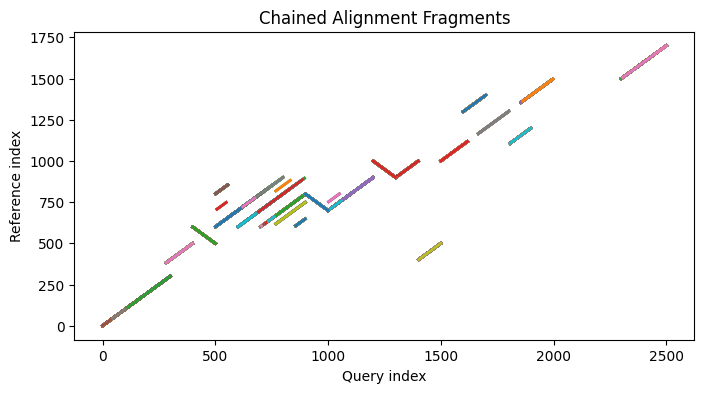

: 

: 

In [ ]:
def filter_fragments(fragments, ref, query,
                     min_len=30,
                     max_err_rate=0.10):
    print("过滤片段")
    print("过滤前数量：" + str(len(fragments)))
    out = []
    cnt1=0
    cnt2=0
    for qs, qe, rs, re, sc, strand in fragments:
        L = qe - qs + 1
        ed = calculate_distance(ref, query, rs, re, qs, qe)
        if L < min_len:
            cnt1+=1
            continue
        
        print(f"rs:{rs}, re:{re}, qs:{qs}, qe:{qe}, L:{L}, ed:{ed}")
        if ed / L > max_err_rate:
            print(f"过滤掉rs:{rs}, re:{re}, qs:{qs}, qe:{qe},因为{ed / L}>{max_err_rate}")
            cnt2+=1
            continue
        # 重新计算节点权重：对齐长度 - 编辑距离
        weight = L - ed
        out.append((qs, qe, rs, re, weight, strand))
    print("过滤后数量：" + str(len(out)))
    print("after filter fragments:",out)
    print(f"过滤完成,由于 L < min_len 的数量：{cnt1},由于 ed / L > max_err_rate 的数量：{cnt2}")
    return out




fragments_all = fragments + fragments_r
print("fragments:",fragments)
print("fragments_r:",fragments_r)
print("fragments_all:",fragments_all)

filtered = filter_fragments(fragments_all, reference, query,
                            min_len=30, max_err_rate=0.10)

plt.figure(figsize=(8,4))
# for qs, qe, rs, re, sc, sgn in filtered:
for qs, qe, rs, re, sc, sgn in filtered:
    if sgn == 1:
        plt.plot([qs, qe], [rs, re], lw=2)
    else:
        # 倒序片段要画反向连线：q从小到大，ref从大到小
        plt.plot([qs, qe], [re, rs], lw=2)

plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Chained Alignment Fragments")
plt.show()

[(1500, 1617, 1000, 1117), (1666, 1801, 1166, 1301), (1855, 1997, 1355, 1497), (282, 399, 382, 499), (501, 800, 601, 900), (1402, 1500, 402, 500), (700, 899, 600, 799), (0, 300, 0, 300), (601, 895, 601, 895), (501, 554, 801, 854), (1000, 1199, 700, 899), (1598, 1699, 1298, 1399), (1807, 1899, 1107, 1199), (2299, 2499, 1499, 1699), (1300, 1399, 900, 999), (768, 899, 618, 749), (856, 898, 606, 648), (1002, 1050, 752, 800), (507, 548, 707, 748), (768, 832, 818, 882), (1200, 1299, 900, 999), (900, 999, 700, 799), (400, 500, 499, 599)]
合并后得到的区间：
  query[1500:1617]  ↔  ref[1000:1117]
  query[1666:1801]  ↔  ref[1166:1301]
  query[1855:1997]  ↔  ref[1355:1497]
  query[282:399]  ↔  ref[382:499]
  query[501:800]  ↔  ref[601:900]
  query[1402:1500]  ↔  ref[402:500]
  query[700:899]  ↔  ref[600:799]
  query[0:300]  ↔  ref[0:300]
  query[601:895]  ↔  ref[601:895]
  query[501:554]  ↔  ref[801:854]
  query[1000:1199]  ↔  ref[700:899]
  query[1598:1699]  ↔  ref[1298:1399]
  query[1807:1899]  ↔  ref[11

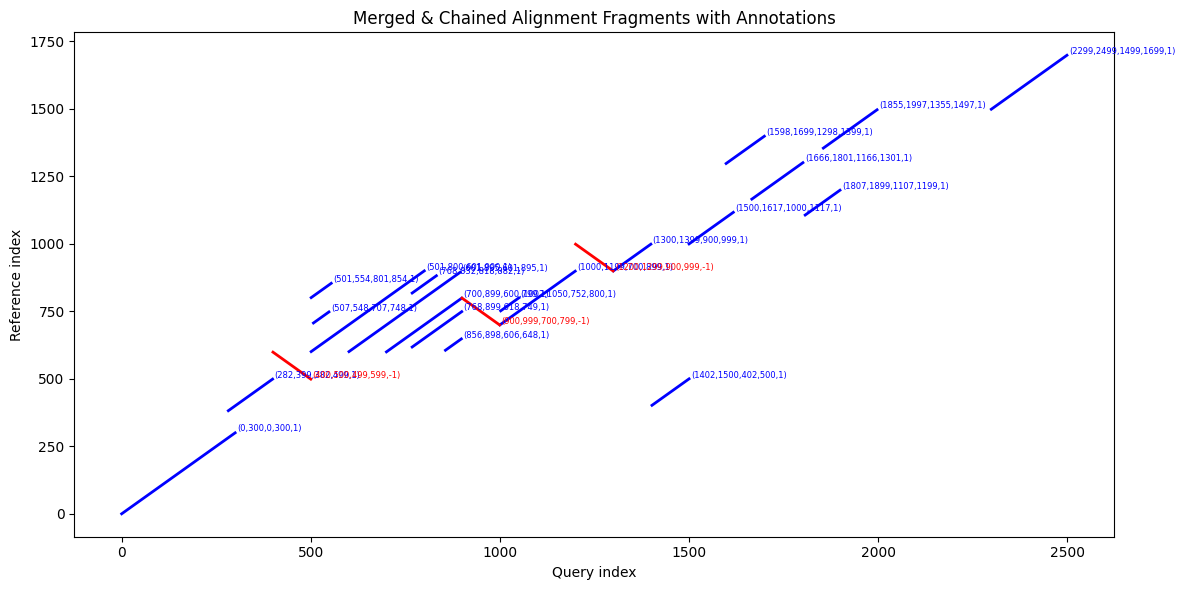

: 

: 

In [ ]:
from collections import defaultdict

merged = merge_aligned_fragments(filtered)
pre_ans = []
for qs, qe, rs, re, strand in merged:
    pre_ans.append((qs, qe, rs, re))
print(pre_ans)



print("合并后得到的区间：")
for qs, qe, rs, re, strand in merged:
    print(f"  query[{qs}:{qe}]  ↔  ref[{rs}:{re}]")

plt.figure(figsize=(12, 6))
for qs, qe, rs, re, strand in merged:
    if strand == 1:
        x_vals = [qs, qe]
        y_vals = [rs, re]
        color = 'b'
    else:
        x_vals = [qs, qe]
        y_vals = [re, rs]  # 反向时交换
        color = 'r'
    plt.plot(x_vals, y_vals, color=color, lw=2)
    # 在每条线的末端标注其元组
    label = f"({qs},{qe},{rs},{re},{strand})"
    plt.text(x_vals[1] + 5, y_vals[1] + 5, label, fontsize=6, color=color)

plt.xlabel("Query index")
plt.ylabel("Reference index")
plt.title("Merged & Chained Alignment Fragments with Annotations")
plt.tight_layout()
plt.show()


In [ ]:
tag=0
print("pre_ans:",pre_ans)
true_ans=[]

cnt=0
while(1):
    cnt+=1
    print(f"第{cnt}次循环：")
    
    choices=[]
    for qs, qe, rs, re in pre_ans:
        if tag>=qs and tag<qe:
            choices.append((qs,qe,rs,re))
            # print("choices:",choices)
    print(f"此时rs<=tag<re的choices:{choices}")
    if(len(choices)>0):
        best=max(choices,key=lambda x:x[1]-tag)
        qs,qe,rs,re=best
        qs1=tag
        qe1=qe+1
        re1=re+1
        rs1=re1+qs1-qe1
        true_ans.append((qs1,qe1,rs1,re1))
        tag=qe1
        print(f"此时best:{best},tag:{tag}")
        
    else :
        print("此时没有rs<=tag<re的choices")
        for qs,qe,rs,re in pre_ans:
            if qs>tag:
                choices.append((qs,qe,rs,re))
        print(f"此时rs>tag的choices:{choices}")
        if(len(choices)>0):
            best=min(choices,key=lambda x:x[0])
            qs,qe,rs,re=best
            qs1=qs
            qe1=qe+1
            re1=re+1
            rs1=re1+qs1-qe1
            true_ans.append((qs1,qe1,rs1,re1))
            tag=qe1
            print(f"此时best:{best},tag:{tag}")
        else:
            break
    print(f"此时的true_ans:{true_ans}")
print("true_ans:",true_ans)


    # cnt+=1
    # if cnt>0:
    #     break
    




pre_ans: [(1500, 1617, 1000, 1117), (1666, 1801, 1166, 1301), (1855, 1997, 1355, 1497), (282, 399, 382, 499), (501, 800, 601, 900), (1402, 1500, 402, 500), (700, 899, 600, 799), (0, 300, 0, 300), (601, 895, 601, 895), (501, 554, 801, 854), (1000, 1199, 700, 899), (1598, 1699, 1298, 1399), (1807, 1899, 1107, 1199), (2299, 2499, 1499, 1699), (1300, 1399, 900, 999), (768, 899, 618, 749), (856, 898, 606, 648), (1002, 1050, 752, 800), (507, 548, 707, 748), (768, 832, 818, 882), (1200, 1299, 900, 999), (900, 999, 700, 799), (400, 500, 499, 599)]
第1次循环：
此时rs<=tag<re的choices:[(0, 300, 0, 300)]
此时best:(0, 300, 0, 300),tag:301
此时的true_ans:[(0, 301, 0, 301)]
第2次循环：
此时rs<=tag<re的choices:[(282, 399, 382, 499)]
此时best:(282, 399, 382, 499),tag:400
此时的true_ans:[(0, 301, 0, 301), (301, 400, 401, 500)]
第3次循环：
此时rs<=tag<re的choices:[(400, 500, 499, 599)]
此时best:(400, 500, 499, 599),tag:501
此时的true_ans:[(0, 301, 0, 301), (301, 400, 401, 500), (400, 501, 499, 600)]
第4次循环：
此时rs<=tag<re的choices:[(501, 800, 60

: 

: 